In [1]:
# These are the libraries will be used.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

from tqdm import tqdm
from dataSet import *
from unet_model import *
from torch.utils.data import DataLoader, random_split
from diceCoefficient import *

In [2]:
# Change these directories as needed

# Image Directories 
# image
dir_image='/home/matmatius/Desktop/astrocyteImages/otsuImages/originalrgb/'
# mask
dir_mask='/home/matmatius/Desktop/astrocyteImages/otsuImages/masksrgb/'
# scale image

In [3]:
dataset=Dataset(dir_image,dir_mask)
model=UNet(1,2, bilinear=False)
loss = nn.CrossEntropyLoss()

In [4]:
x=dataset[0]['image']
y=dataset[0]['mask']
print(x.shape,y.shape)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


In [5]:
z=model(x.view(-1,1,128,128).float())
print(z.shape)

torch.Size([1, 2, 128, 128])


 split dataset

In [6]:
# Split dataset

torch.manual_seed(0)
np.random.seed(0)


val_percent=0.30

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, validation_dataset= random_split(dataset, [n_train, n_val])

https://pytorch.org/docs/stable/notes/randomness.html

please see the link above about seed and reproducibility.

In [7]:
# Augment Dataset
augmented=augmentData(train_set)

# create augmented dataset

train_dataset=augDateSet(augmented['image'],augmented['mask'])

100%|██████████| 83/83 [00:01<00:00, 50.34it/s]


In [8]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5)

In [9]:
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
torch.cuda.is_available()

True

In [11]:
n_epochs=8
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

#coeffcients
listS= []
listP = []

listDC = []

Loss=0
start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)

for epoch in range(n_epochs):
    print('epoch: '+str(epoch))
    
    for x in tqdm(train_loader):

        model.train() 
        #clear gradient optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        optimizer.zero_grad()
        #make a prediction 
        z = model(x['image'].view(-1,1,128,128).float().to(device))
        # calculate loss 
        loss = criterion(z, x['mask'][:,0].to(device))
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
    loss_list.append(loss.data)
        
    correct=0
    for x in tqdm(validation_loader):
        y_test=x['mask'].to(device)
        # set model to eval 
        
        #make a prediction 
        z = model(x['image'].view(-1,1,128,128).float().to(device))
        #find max 
        _, yhat = torch.max(z.data, 1)
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        
        correct += (yhat == y_test).sum().item()
        
        
        yhat=yhat.to('cpu').detach()[0]   
    
        #listS.append(sensitivity(yhat.numpy(), x['mask'][0].numpy()))
        #listP.append(precision(yhat.numpy(), x['mask'][0].numpy()))
        #listDC.append(diceCoef(yhat.numpy(), x['mask'][0].numpy()))
        
        
    accuracy=correct/(128*128*N_test*5)
    accuracy_list.append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 1


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 2


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 3


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 4


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 5


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 6


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 7


100%|██████████| 7/7 [00:00<00:00, 12.45it/s]


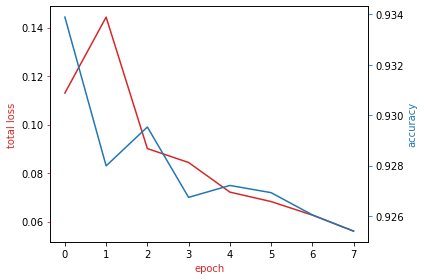

In [12]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [ ]:
!pwd

In [ ]:
#save model

#torch.save(model.state_dict(), '/home/matmatius/Desktop/astrocyteSegmentation/trainedUNet.pt')

#model.load_state_dict(torch.load('/home/matmatius/Desktop/astrocyteSegmentation/trainedUNetNoBilinear.pt'))

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device=device)

In [13]:
def plotresult(x):
    z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    fig, axs = plt.subplots(1, 3, figsize=(12, 12))
    axs[0].imshow(x['image'][0],cmap='gray')
    axs[0].set_title('input network')
    axs[1].imshow(x['mask'][0],cmap='gray')
    axs[1].set_title('ground truth')
    axs[2].imshow(yhat,cmap='gray')
    axs[2].set_title('network output') 
    plt.show()
    

In [14]:
len(validation_dataset)

35

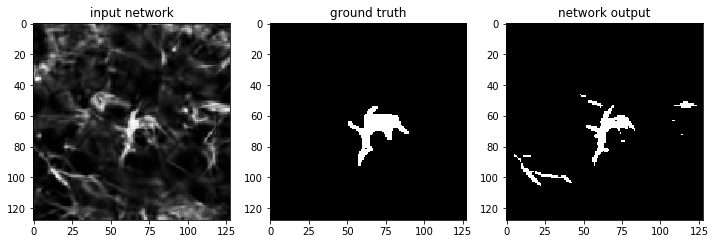

In [15]:
index=0
plotresult(validation_dataset[index])

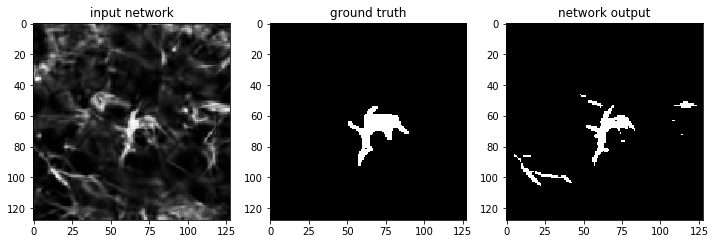

index =0
sensitivity = 0.6373390557939914
precision = 0.6123711340206186
dice coeffcient = 0.6246056782334385


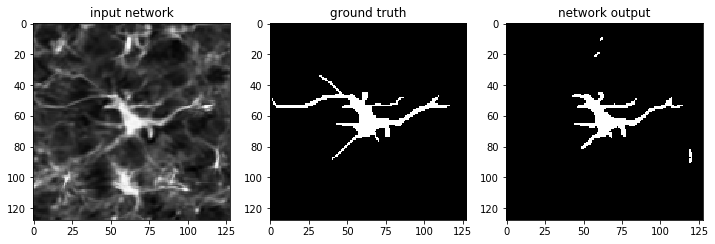

index =1
sensitivity = 0.6960526315789474
precision = 0.8686371100164204
dice coeffcient = 0.7728268809349891


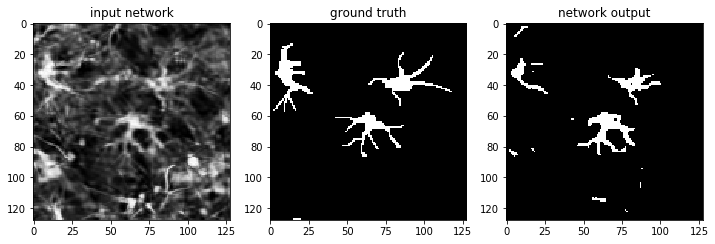

index =2
sensitivity = 0.5948081264108352
precision = 0.7064343163538874
dice coeffcient = 0.6458333333333334


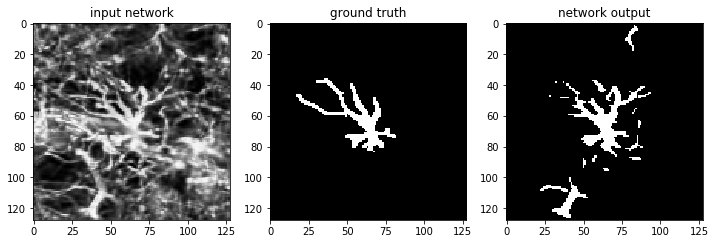

index =3
sensitivity = 0.6789554531490015
precision = 0.44377510040160645
dice coeffcient = 0.5367334547662417


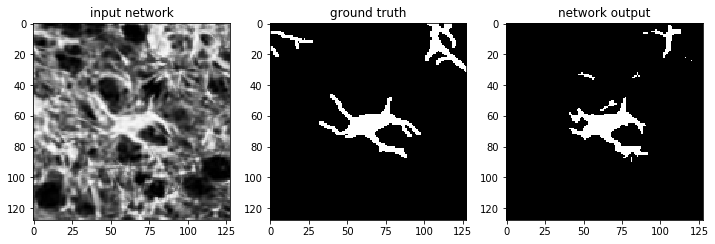

index =4
sensitivity = 0.5680580762250453
precision = 0.7834793491864831
dice coeffcient = 0.6586007364544977


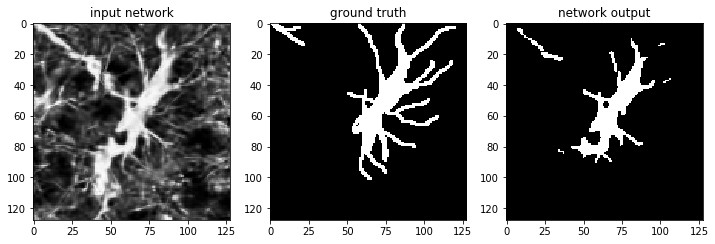

index =5
sensitivity = 0.543525571273123
precision = 0.826302729528536
dice coeffcient = 0.6557269445356088


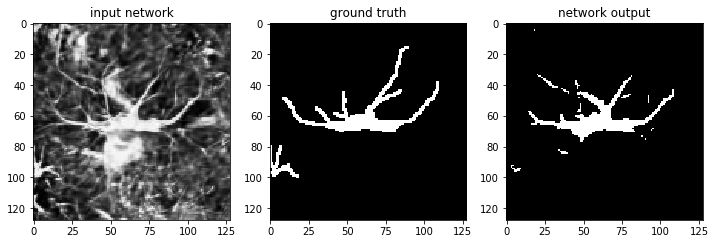

index =6
sensitivity = 0.6339285714285714
precision = 0.7395833333333334
dice coeffcient = 0.6826923076923077


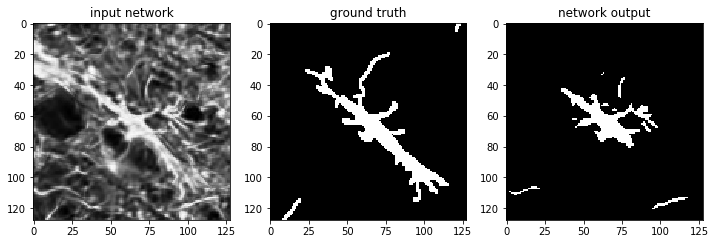

index =7
sensitivity = 0.4111600587371512
precision = 0.6973848069738481
dice coeffcient = 0.5173210161662818


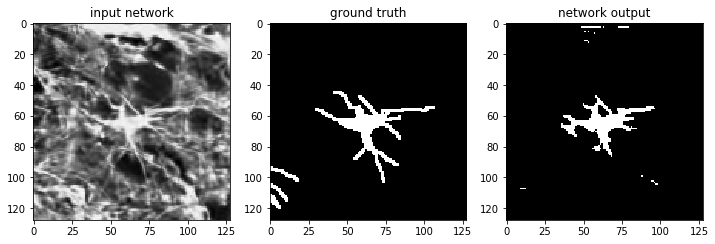

index =8
sensitivity = 0.5278080697928026
precision = 0.7503875968992249
dice coeffcient = 0.6197183098591549


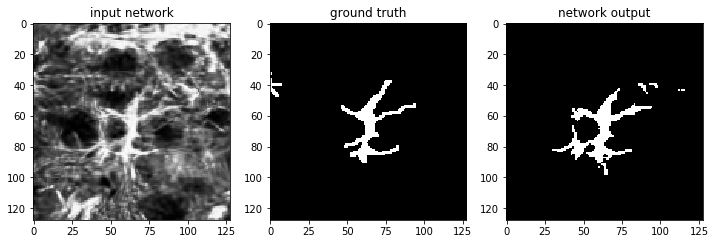

index =9
sensitivity = 0.771900826446281
precision = 0.6057068741893644
dice coeffcient = 0.6787790697674418


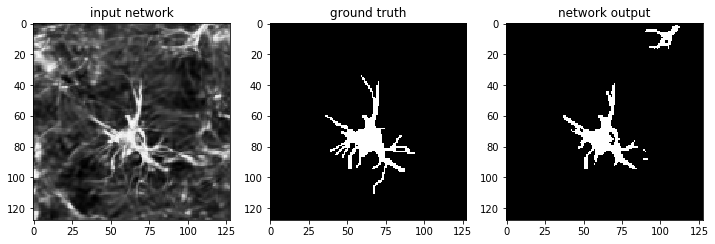

index =10
sensitivity = 0.7561608300907912
precision = 0.7752659574468085
dice coeffcient = 0.7655942219304005


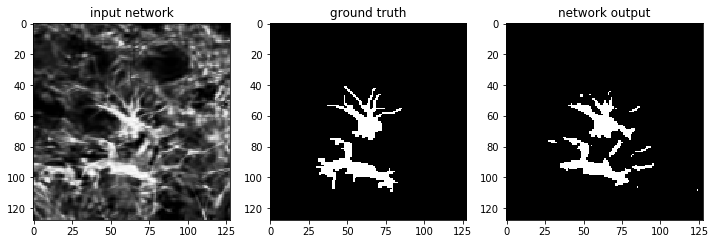

index =11
sensitivity = 0.7701396348012889
precision = 0.7742980561555075
dice coeffcient = 0.7722132471728594


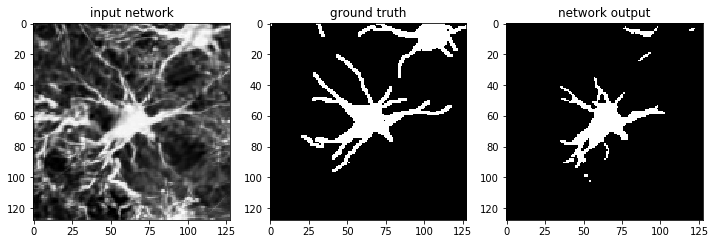

index =12
sensitivity = 0.44616977225672877
precision = 0.8450980392156863
dice coeffcient = 0.5840108401084011


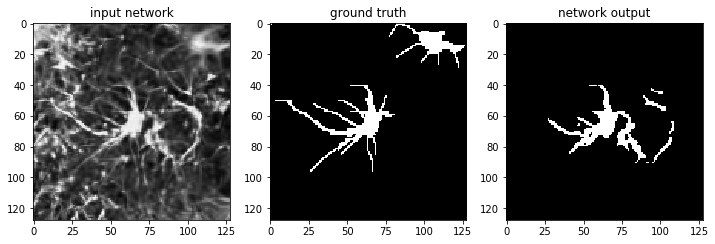

index =13
sensitivity = 0.4357707509881423
precision = 0.5856573705179283
dice coeffcient = 0.49971671388101985


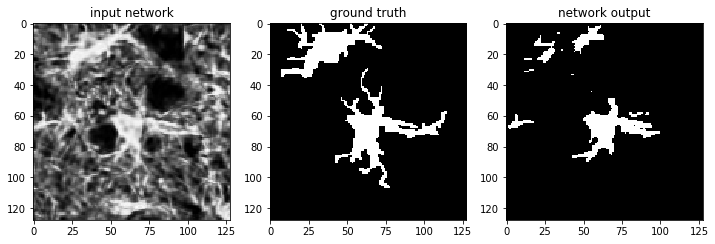

index =14
sensitivity = 0.4748051948051948
precision = 0.8978388998035364
dice coeffcient = 0.6211348963642541


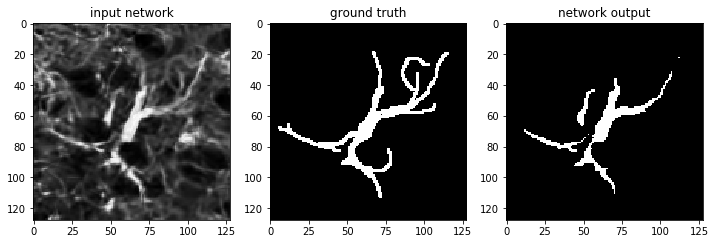

index =15
sensitivity = 0.5202312138728323
precision = 0.8181818181818182
dice coeffcient = 0.6360424028268551


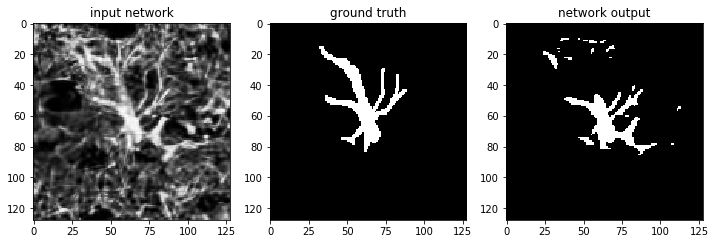

index =16
sensitivity = 0.579295154185022
precision = 0.6232227488151659
dice coeffcient = 0.6004566210045662


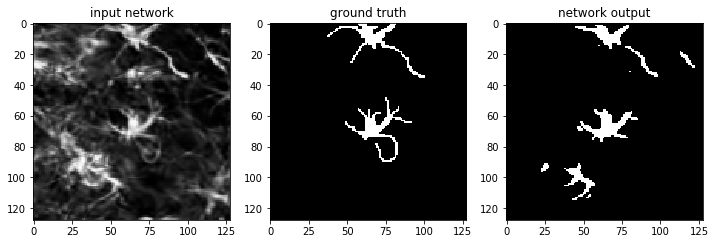

index =17
sensitivity = 0.7154088050314465
precision = 0.6050531914893617
dice coeffcient = 0.6556195965417867


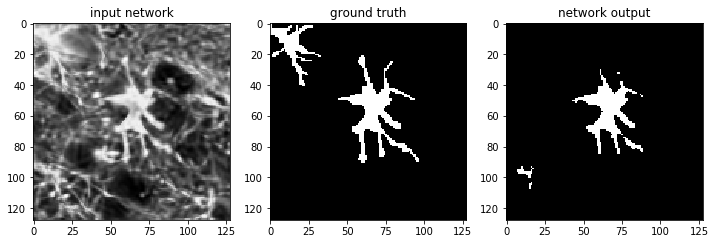

index =18
sensitivity = 0.5486935866983373
precision = 0.90234375
dice coeffcient = 0.6824224519940916


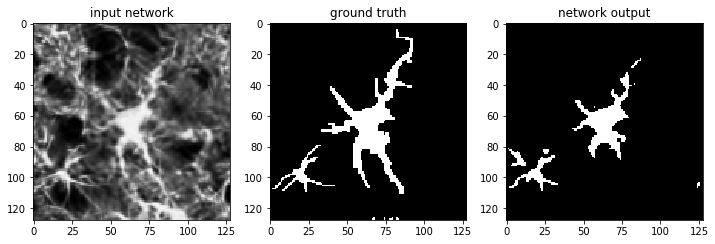

index =19
sensitivity = 0.5591182364729459
precision = 0.8932764140875133
dice coeffcient = 0.6877567789646672


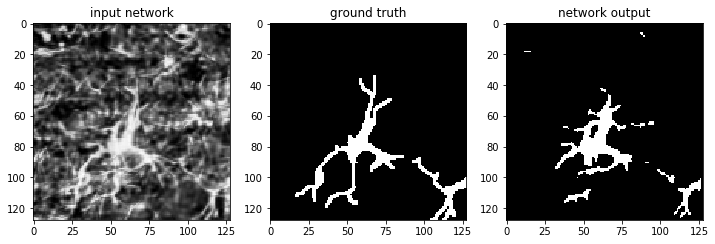

index =20
sensitivity = 0.5998300764655905
precision = 0.6788461538461539
dice coeffcient = 0.6368967072620658


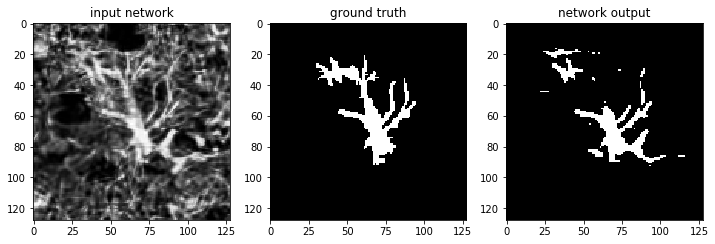

index =21
sensitivity = 0.6282527881040892
precision = 0.7168610816542949
dice coeffcient = 0.6696384348687469


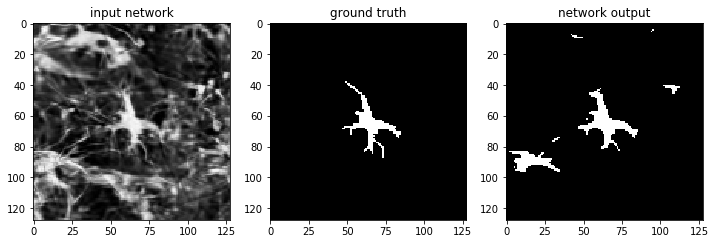

index =22
sensitivity = 0.9036827195467422
precision = 0.48042168674698793
dice coeffcient = 0.6273352999016716


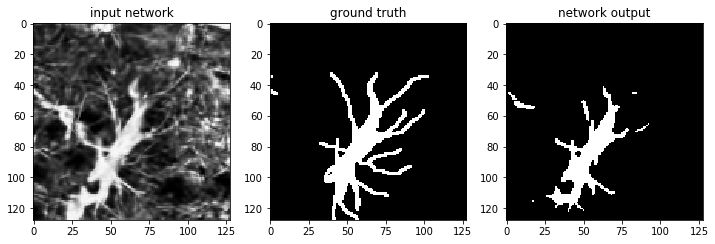

index =23
sensitivity = 0.5720903300521135
precision = 0.8415672913117547
dice coeffcient = 0.6811444329541537


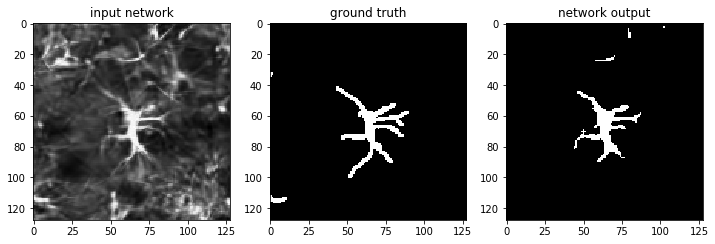

index =24
sensitivity = 0.6376811594202898
precision = 0.7857142857142857
dice coeffcient = 0.704


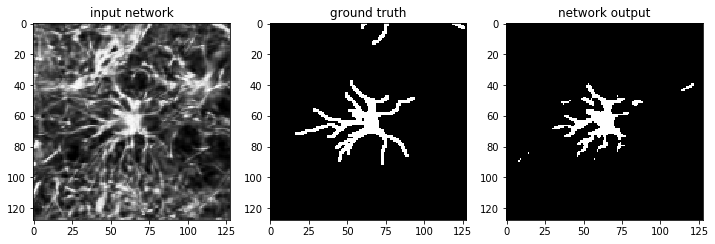

index =25
sensitivity = 0.5699263932702419
precision = 0.8249619482496194
dice coeffcient = 0.6741293532338308


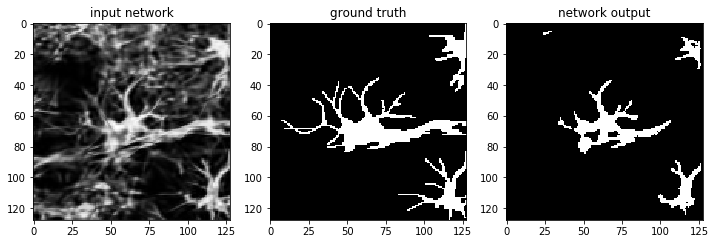

index =26
sensitivity = 0.5627221940071102
precision = 0.9303106633081444
dice coeffcient = 0.7012658227848101


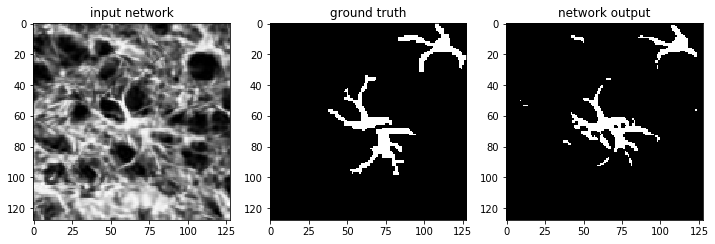

index =27
sensitivity = 0.6523855890944499
precision = 0.7545045045045045
dice coeffcient = 0.6997389033942559


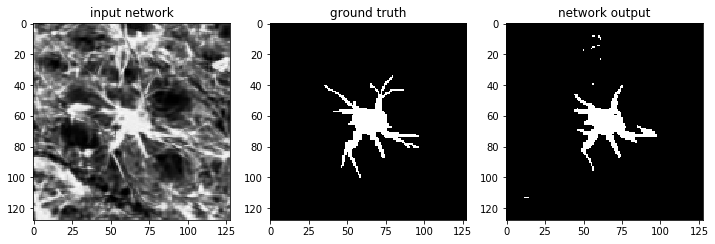

index =28
sensitivity = 0.8037267080745342
precision = 0.8468586387434555
dice coeffcient = 0.8247291268323773


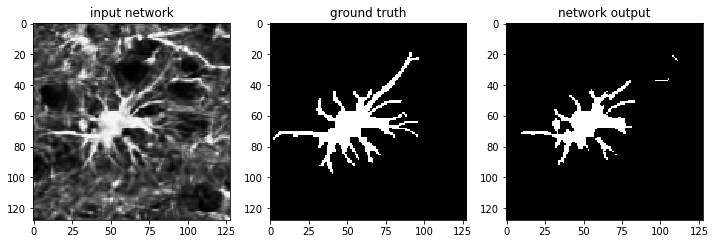

index =29
sensitivity = 0.6802773497688752
precision = 0.9207507820646507
dice coeffcient = 0.7824545857332743


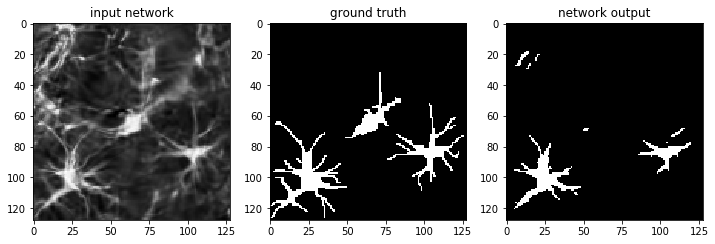

index =30
sensitivity = 0.4530909090909091
precision = 0.8676880222841226
dice coeffcient = 0.5953177257525084


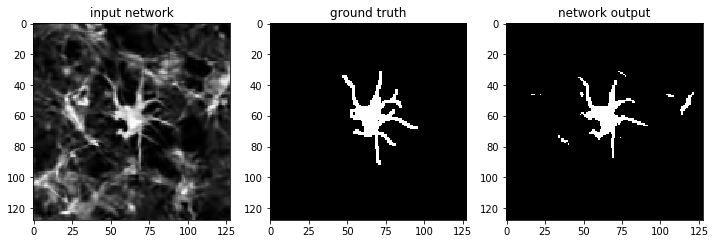

index =31
sensitivity = 0.6741405082212257
precision = 0.7940140845070423
dice coeffcient = 0.7291835084882781


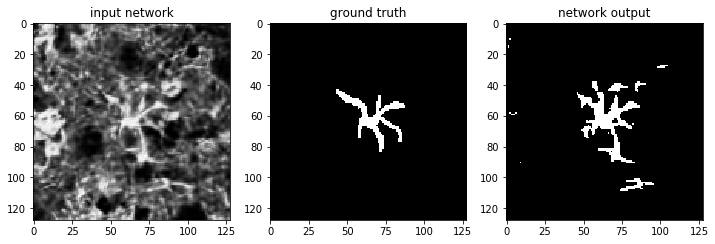

index =32
sensitivity = 0.7672811059907834
precision = 0.45
dice coeffcient = 0.5672913117546848


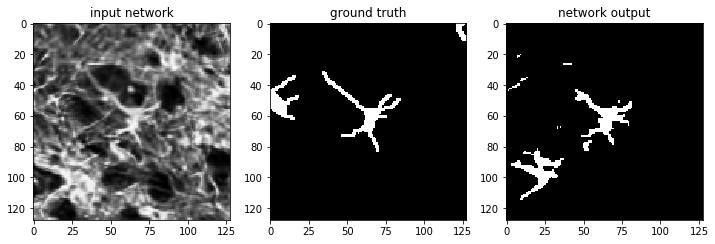

index =33
sensitivity = 0.424886191198786
precision = 0.37889039242219213
dice coeffcient = 0.4005722460658083


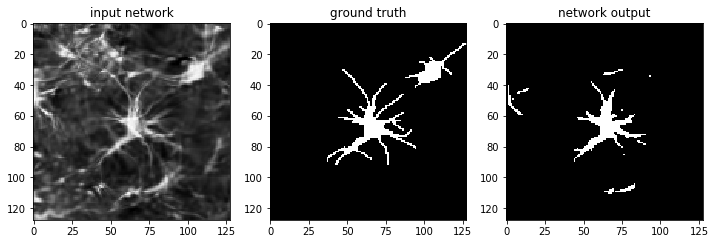

index =34
sensitivity = 0.5197674418604651
precision = 0.7292006525285482
dice coeffcient = 0.6069246435845214


In [16]:
for index in range(len(validation_dataset)):
    plotresult(validation_dataset[index])
    x=validation_dataset[index]
    z=z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    
    
    yhat=yhat.to('cpu').detach()[0]
    print('index ='+str(index))
    
    print('sensitivity = '+str(sensitivity(yhat.numpy(), x['mask'][0].numpy())))
    print('precision = '+ str(precision(yhat.numpy(), x['mask'][0].numpy())))
    print('dice coeffcient = '+ str(diceCoef(yhat.numpy(), x['mask'][0].numpy())))
    
    

In [17]:
index=0
x=validation_dataset[index]
z=z=model(x['image'].view(-1,1,128,128).float().to(device))
_, yhat = torch.max(z.data, 1)
yhat=yhat.to('cpu').detach()[0]
#yhat=yhat.numpy()

#truePos(pred_labels, true_labels)
print('computed by method')
print('True Positive: '+str(truePos(yhat.numpy(), x['mask'].numpy())))
print('Dice Coefficent: ' +str(diceCoef(yhat.numpy(), x['mask'][0].numpy())))
print('computed with other method')
TP=(yhat*x['mask'][0]).sum().item()
DC=2*(yhat*x['mask'][0]).sum().item()/(yhat.sum().item()+x['mask'][0].sum().item())
print("TP: "+str(TP))
print("DC: "+ str(DC))

computed by method
True Positive: 297
Dice Coefficent: 0.6246056782334385
computed with other method
TP: 297
DC: 0.6246056782334385


In [18]:
listSv= []
listPv = []

listDCv = []

for index in range(len(validation_dataset)):
    x=validation_dataset[index]
    z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    
    
    listSv.append(sensitivity(yhat.numpy(), x['mask'][0].numpy()))
    listPv.append(precision(yhat.numpy(), x['mask'][0].numpy()))
    listDCv.append(diceCoef(yhat.numpy(), x['mask'][0].numpy()))

    
listSt= []
listPt = []

listDCt = []

for index in range(len(train_dataset)):
    x=train_dataset[index]
    z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    
    
    listSt.append(sensitivity(yhat.numpy(), x['mask'][0].numpy()))
    listPt.append(precision(yhat.numpy(), x['mask'][0].numpy()))
    listDCt.append(diceCoef(yhat.numpy(), x['mask'][0].numpy()))
    
    

Validation Dataset
sensitivity:  mean=0.6091163166915625, std=0.11639638775414152
precision:  mean=0.7358539652714973, std=0.1420316638158427
dice coeffcient:  mean=0.6513836458612338, std=0.08437172960048266


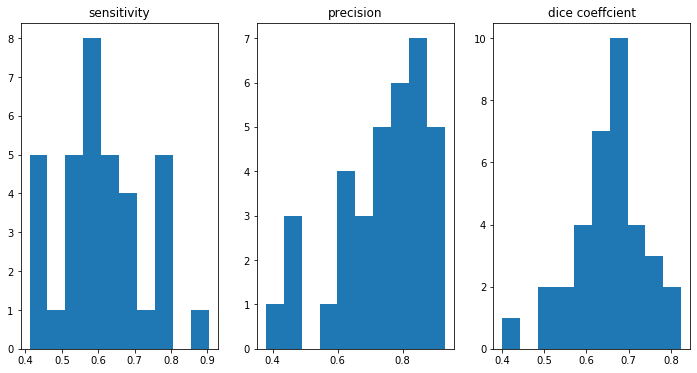

Train Dataset
sensitivity:  mean=0.6518476718591933, std=0.13631443388309006
precision:  mean=0.7732565421673194, std=0.14006571189559935
dice coeffcient:  mean=0.6897489585238349, std=0.09579943437354738


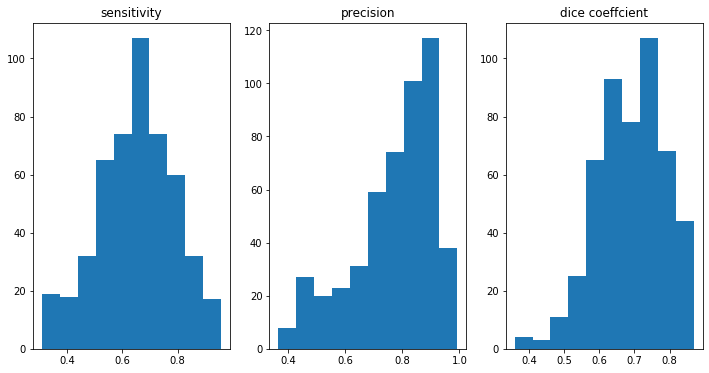

In [19]:
#plot coeffcients

print('Validation Dataset')
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].hist(listSv)
axs[0].set_title('sensitivity')
print('sensitivity:  mean='+ str(np.mean(listSv))+', std='+str(np.std(listSv)))
axs[1].hist(listPv)
axs[1].set_title('precision')
print('precision:  mean='+ str(np.mean(listPv))+', std='+str(np.std(listPv)))
axs[2].hist(listDCv)
axs[2].set_title('dice coeffcient')
print('dice coeffcient:  mean='+ str(np.mean(listDCv))+', std='+str(np.std(listDCv)))
plt.show()


print('Train Dataset')
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].hist(listSt)
axs[0].set_title('sensitivity')
print('sensitivity:  mean='+ str(np.mean(listSt))+', std='+str(np.std(listSt)))
axs[1].hist(listPt)
axs[1].set_title('precision')
print('precision:  mean='+ str(np.mean(listPt))+', std='+str(np.std(listPt)))
axs[2].hist(listDCt)
axs[2].set_title('dice coeffcient')
print('dice coeffcient:  mean='+ str(np.mean(listDCt))+', std='+str(np.std(listDCt)))
plt.show()


# Histograms of each instance output, each pixel. 128 x128 x2

In [20]:
def plotHistInst(index1,index2):

    #index1=65
    #index2=65

    channel_black_v=[]
    channel_white_v=[]
    channel_black_t=[]
    channel_white_t=[]

    for index in range(len(train_dataset)):
        x=train_dataset[index]
        z=model(x['image'].view(-1,1,128,128).float().to(device)).to('cpu').detach()
        channel_black_t.append(z[0,0,index1,index2].item())
        channel_white_t.append(z[0,1,index1,index2].item())

    for index in range(len(validation_dataset)):
        x=validation_dataset[index]
        z=model(x['image'].view(-1,1,128,128).float().to(device)).to('cpu').detach()
        channel_black_v.append(z[0,0,index1,index2].item())
        channel_white_v.append(z[0,1,index1,index2].item())
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    print("pixel: ("+str(index1)+' , '+str(index2)+")")
    axs[0].hist(channel_black_t)
    axs[0].set_xlabel('raw value')
    axs[0].set_ylabel('frequencies')
    axs[0].set_title('black output, train data')
    axs[1].hist(channel_white_t)
    axs[1].set_xlabel('raw value')
    axs[1].set_ylabel('frequencies')
    axs[1].set_title('white output, train data')
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].hist(channel_black_v)
    axs[0].set_xlabel('raw value')
    axs[0].set_ylabel('frequencies')
    axs[0].set_title('black output, validation data')
    axs[1].hist(channel_white_v)
    axs[1].set_xlabel('raw value')
    axs[1].set_ylabel('frequencies')
    axs[1].set_title('white output, validation data')

pixel: (8 , 120)


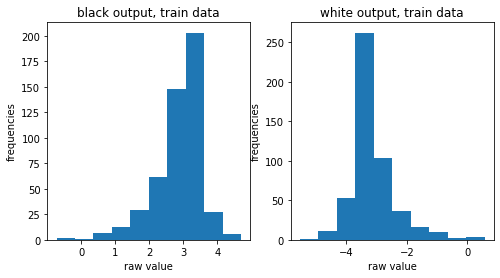

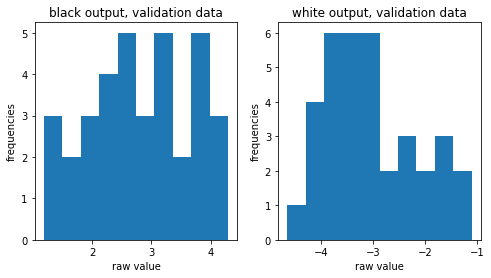

In [21]:
plotHistInst(8,120)

pixel: (20 , 32)


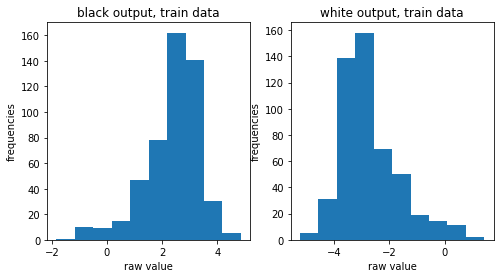

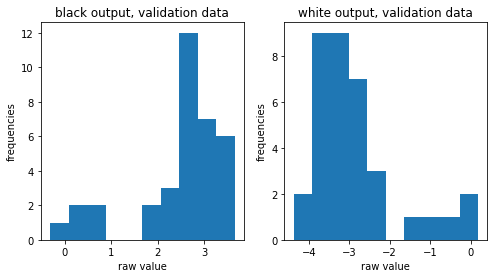

In [22]:
plotHistInst(20,32)

pixel: (58 , 44)


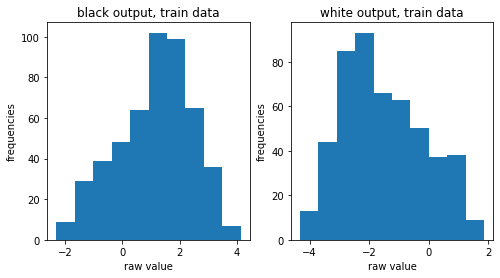

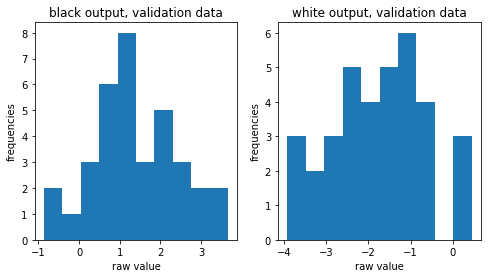

In [23]:
plotHistInst(58,44)

pixel: (65 , 65)


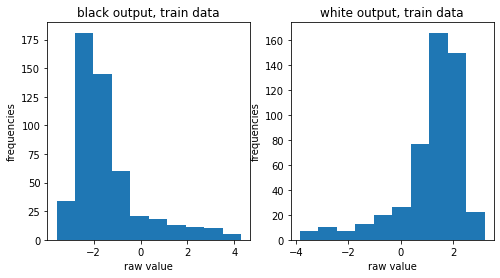

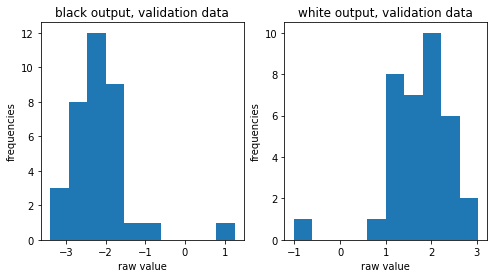

In [24]:
plotHistInst(65,65)

pixel: (24 , 32)


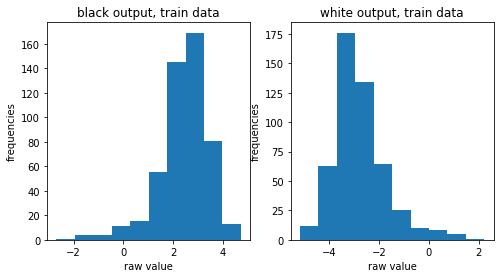

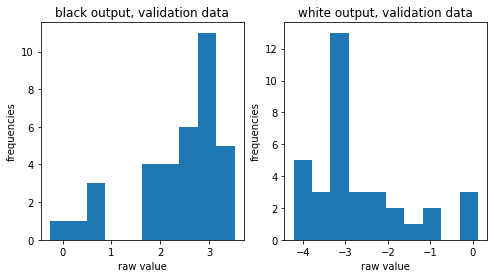

In [25]:
plotHistInst(24,32)

pixel: (23 , 80)


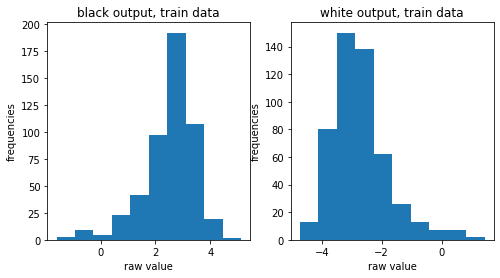

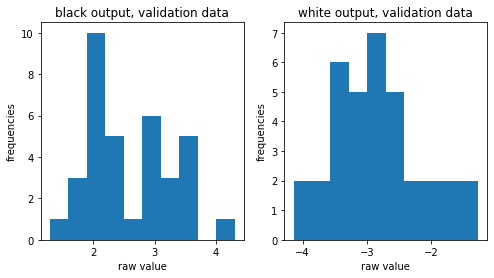

In [26]:
plotHistInst(23,80)

pixel: (96 , 23)


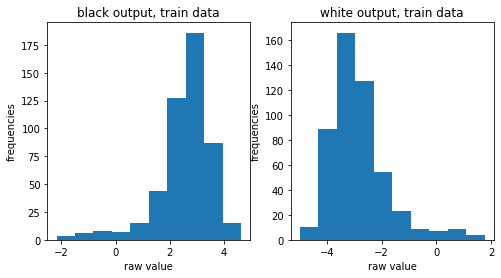

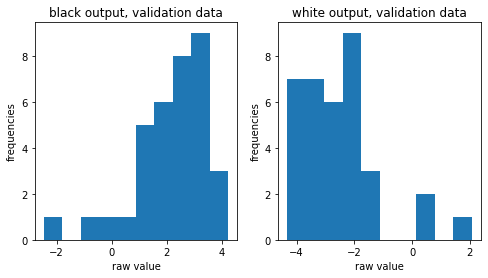

In [27]:
plotHistInst(96,23)